<a href="https://colab.research.google.com/github/chay2405/mnist-edge-ai-classifier/blob/main/Edge_AI_Image_Classifier_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow matplotlib

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Expand dims for CNN input
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# Model
model = models.Sequential([
    layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Training
history = model.fit(x_train, y_train, epochs=5, validation_split=0.1)

# Evaluation
loss, acc = model.evaluate(x_test, y_test)
print(f"✅ Test Accuracy: {acc*100:.2f}%")


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.8806 - loss: 0.3956 - val_accuracy: 0.9780 - val_loss: 0.0738
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - accuracy: 0.9790 - loss: 0.0678 - val_accuracy: 0.9853 - val_loss: 0.0497
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.9863 - loss: 0.0433 - val_accuracy: 0.9838 - val_loss: 0.0565
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.9893 - loss: 0.0327 - val_accuracy: 0.9888 - val_loss: 0.0392
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.9917 - loss: 0.0267 - val_accuracy: 0.9877 - val_loss: 0.0385
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9846 - loss: 0.0451
✅ Test Accuracy: 98.77%


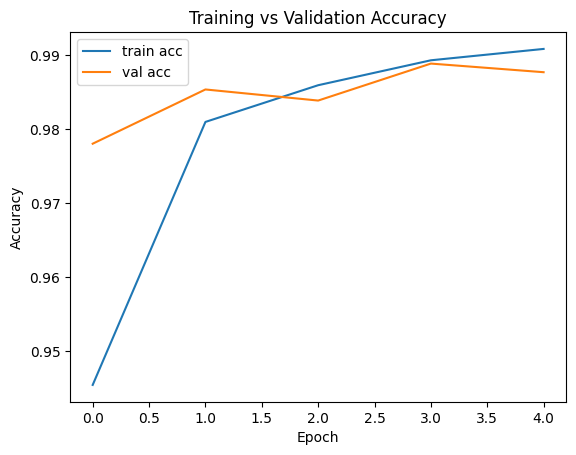

In [3]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.show()


In [4]:
# Save Keras model
model.save("mnist_cnn.h5")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open("mnist_cnn.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Model converted to mnist_cnn.tflite")


Saved artifact at '/tmp/tmpwf6zvpon'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  137909790065680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137909793078928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137909790064720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137909790066256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137909790065872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137909790067408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137909793078736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137909790066448: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Model converted to mnist_cnn.tflite


In [5]:
import numpy as np

interpreter = tf.lite.Interpreter(model_path="mnist_cnn.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test on 5 images
for i in range(5):
    input_data = np.expand_dims(x_test[i], axis=0).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    pred = np.argmax(output)
    print(f"Image {i}: Predicted={pred}, Actual={y_test[i]}")


Image 0: Predicted=7, Actual=7
Image 1: Predicted=2, Actual=2
Image 2: Predicted=1, Actual=1
Image 3: Predicted=0, Actual=0
Image 4: Predicted=4, Actual=4


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
